# Quenching Timescales

This notebook computes the quenching times and infall times for satellites in the Justice League simulations. In contrast to other notebooks, here we use the sSFR over time to determine the quenching time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pickle
import pynbody

mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

In [2]:
# it is convenient to define these functions to read in our datasets for us

def read_z0(simname):
    '''Function to read in the data file which contains z=0 information for the various halos.'''
    data = []
    with open('../../Data/z0_data/'+ simname + '.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data1 = pd.DataFrame(data)
    return data1
    
def read_timesteps(simname):
    '''Function to read in the timestep bulk-processing datafile (from /home/akinhol/Data/Timescales/DataFiles/{name}.data)'''
    data = []
    with open(f'../../Data/timesteps_data/{simname}.data','rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
    
    data = pd.DataFrame(data)
    return data

### Proof of Concept

We test out this method of determining the quenching time on Halo 36 from simulation `h148`. First, we need to load in the data and make sure that our timesteps and redshift 0 data match. 

In [3]:
sim = 'h148'
i = 36

z0 = read_z0(sim)
print(np.unique(z0.haloid))
timesteps = read_timesteps(sim)

z0 = z0[z0.haloid==i]
print(np.array(np.unique(timesteps.z0haloid),dtype=int))
timesteps = timesteps[timesteps.z0haloid==i]

[   1    2    3    5    6    9   10   11   13   14   21   24   27   28
   30   32   36   37   41   45   47   48   58   61   65   68   80   81
   96  105  119  127  128  136  163  212  265  278  283  329  372  377
  384  386  442  491  620  678  699  711  759  914 1004 1024 1201 1217
 1451 2905 5039]
[   2    3    5    6    9   10   11   13   14   21   24   27   28   30
   32   36   37   41   45   47   48   58   61   65   68   80   81   96
  105  119  127  128  136  163  212  265  278  283  329  372  377  384
  386  442  491  620  678  699  759  914 1004]


Next, we need to determine the star-formation-rate over time for the main progenitor branch. We have two ways of doing this:

1. computing the star-formation-history from the redshift 0 stellar content (extrapolating stellar masses and ages)
2. computing the instantaneous star-formation-rate at each *snapshot*

Both of these are done in bulk processing scripts and stored in the z0 and timesteps data, respectively. Here's what the plots look like: 

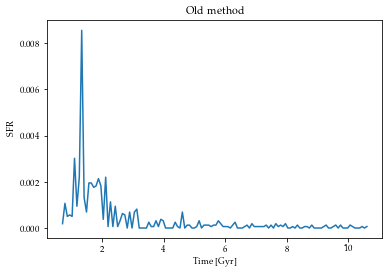

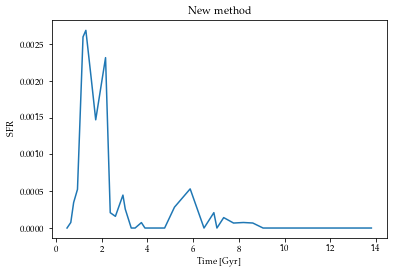

In [10]:
# the old method, using the z0 star-formation-history to get SFR vs time in 100 Myr bins
sfh, binEdges = z0.sfh.tolist()[0], z0.sfhbins.tolist()[0] # the SFR and the bins are stored in the dataset as 'sfh' and 'sfhbins'
bincenters = 0.5*(binEdges[1:] + binEdges[:-1]) # convert the 'sfhbins' data from the edges to the centers, to plot as a line
plt.plot(bincenters,sfh)
plt.title('Old method')
plt.xlabel('Time [Gyr]')
plt.ylabel('SFR')
plt.show()

# the new method, using the instantanous sfr at each snapshot
sfr, mstar, time = np.array(timesteps.sfr,dtype=float), np.array(timesteps.mstar, dtype=float), np.array(timesteps.time,dtype=float)
sfr = sfr[np.argsort(time)]
mstar = mstar[np.argsort(time)]
time = np.sort(time) # sorting these arrays will prove useful
plt.title('New method')
plt.plot(time,sfr)
plt.xlabel('Time [Gyr]')
plt.ylabel('SFR')
plt.show()

Clearly, our new method provides a less granular view of the star-formation history. However, it's much more flexible, as we also know the instantanous stellar mass at each snapshot, so we can compute the instantaneous *specific* star-formation rate, a more useful quantity.

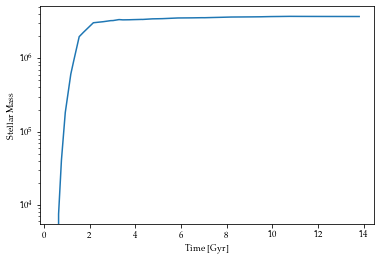

In [11]:
plt.plot(time,mstar)
plt.semilogy()
plt.xlabel('Time [Gyr]')
plt.ylabel('Stellar Mass')
plt.show()

/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


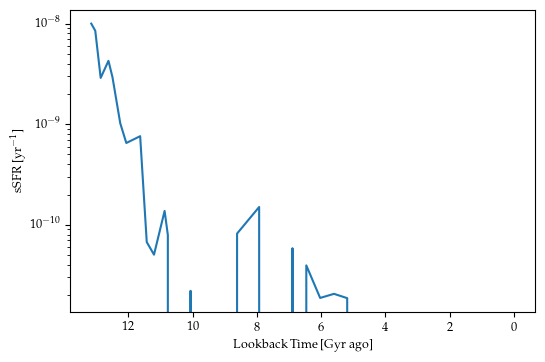

In [12]:
sSFR = sfr/mstar 
lbt = 13.8007 - time # lookback time is 'Gyr ago'
plt.figure(dpi=100)
plt.plot(lbt, sSFR)
plt.xlabel('Lookback Time [Gyr ago]')
plt.ylabel(r'sSFR [yr$^{-1}$]')
plt.semilogy()
plt.gca().invert_xaxis()
plt.show()

Now we want to use this sSFR list to compute the quenching *time*. 

In [13]:
thresh = 1e-11

if z0.sSFR.tolist()[0] < thresh: # if the sSFR is less than the threshold at z=0, then the halo is quenched
    # so we calculate the quenching time
    for i in range(0, len(lbt)): 
        t = np.flip(lbt)[i] # start from the most recent time, and go backwards
        s = np.flip(sSFR)[i] 
        # this is the reason we sorted our arrays earlier--its necessary in order to go backwards in time (and not in a random order)
        if s > thresh: # at the first point where the sSFR is greater than our threshold, call that the quenching time
            print(f'Quenched (sSFR = {s}) {t} Gyr ago')
            tq = t # store this time as tq
            break
        else:
            continue
else:
    # otherwise, the halo is unquenched, so its not useful to calculate the quenching time
    print('Unquenched')

Quenched (sSFR = 1.8667606880871413e-11) 5.191869273211019 Gyr ago


In [28]:
def read_old_data():
    '''Function to read in the resulting data file which contains quenching and infall times'''
    data = []
    with open('/home/akinshol/Data/Timescales/QuenchingTimescales_F19.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data

old_data = read_old_data()
print(old_data[old_data.sim=='h329'].haloid)
print(old_data[old_data.sim=='h329'].tquench)

51     11
52     33
53    133
54    137
Name: haloid, dtype: int64
51    0.3688884118204676
52     5.275914298799698
53     9.996300263992152
54     9.004573080963421
Name: tquench, dtype: object


# Scaling Up

Now that we have a reliable method to compute the quenching time from the sSFR, we need to scale this up and run it on *all the satellites that are quenched*. That's what this next cell does. The resulting data is stored at `/Data/QuenchingTimescales.data`. 

In [14]:
names = ['h148','h242','h229','h329']

q_thresh = 1e-11 # yr^(-1)
i_thresh = 1 # Rvir

age = 13.800797497330507

with open('../../Data/QuenchingTimescales.data','wb') as f:
    for name in names:
        print(f'Simulation {name}')
        
        z0_all = read_z0(name) # the datasets for the simulation as a whole
        timesteps_all = read_timesteps(name)
        
        haloids = np.unique(np.array(timesteps_all.z0haloid, dtype=int)) # all the unique haloids we're interested in

        for haloid in haloids: # for each satellite
            z0 = z0_all[z0_all.haloid==haloid] # the datasets with *just this specific satellite*, a subset of the datasets previously defined
            timesteps = timesteps_all[np.array(timesteps_all.z0haloid,dtype=int)==haloid]
            
            # get the quenching time
            
            sfr, mstar, time = np.array(timesteps.sfr,dtype=float), np.array(timesteps.mstar,dtype=float), np.array(timesteps.time,dtype=float)
            sfr = sfr[np.argsort(time)]
            mstar = mstar[np.argsort(time)]
            time = np.sort(time)

            sSFR = sfr/mstar
            lbt = 13.8007 - time
            
            is_quenched = z0.sSFR.tolist()[0] < q_thresh # boolean expression to determine whether the satellite is quenched
            # is its z=0 sSFR below the threshold? 
            
            if is_quenched:
                # then the halo is quenched, so we calculate the quenching time
                for i in range(0,len(lbt)):
                    t = np.flip(lbt)[i]
                    s = np.flip(sSFR)[i]
                    if s > 1e-11:
                        print(f'\t Halo {haloid}, Quenched (sSFR = {s}) {t} Gyr ago', end='  ')
                        tq = t
                        break
                    else:
                        continue
                        
                # lower limit on quenching time (same thing, but with 2e-11 as the threshold)
                for i in range(0,len(lbt)):
                    t = np.flip(lbt)[i]
                    s = np.flip(sSFR)[i]
                    if s > 2e-11:
                        tq_lower = t
                        break
                    else:
                        continue
                        
                # upper limit on quenching timem (same thing, but with 0 as the threshold)
                for i in range(0,len(lbt)):
                    t = np.flip(lbt)[i]
                    s = np.flip(sSFR)[i]
                    if s > 0:
                        tq_upper = t
                        break
                    else:
                        continue     
            else:
                print(f'\t Halo {haloid}, Unquenched at z = 0', end='  ')
                tq = None
                tq_lower = None
                tq_upper = None
                
            
            # get the infall time
            
            dist = np.array(timesteps.h1dist, dtype=float) # in Rvir
            time = age - np.array(timesteps.time, dtype=float) # in Gyr ago

            try:
                ti = np.max(time[dist <= i_thresh]) # maximum lookback time at which sat is < 1 Rvir from host (max LBT = earliest time)
                print(f'\t Halo {haloid}, infall {ti} Gyr ago')
            except ValueError:
                print(f'\t Halo {haloid}, never infell')
                ti = None
                
            try:
                ti_lower = np.max(time[dist <= 1.1])
            except ValueError:
                ti_lower = None
                
            try:
                ti_upper = np.max(time[dist <= 0.9])
            except ValueError:
                ti_upper = None
                
            z0mstar = mstar[-1] # for reference
            z0nstar = z0.n_star.tolist()[0]

            pickle.dump({
                'haloid':haloid,
                'quenched':is_quenched,
                'tquench':tq,
                'tquench_lower': tq_lower,
                'tquench_upper': tq_upper,
                'tinfall':ti,
                'tinfall_lower': ti_lower,
                'tinfall_upper': ti_upper,
                'M_star': z0mstar,
                'n_star': z0nstar,
                'sim':name                
            }, f, protocol=2)
            

Simulation h148
	 Halo 2, Unquenched at z = 0  	 Halo 2, infall 1.7239215218961164 Gyr ago
	 Halo 3, Unquenched at z = 0  	 Halo 3, infall 4.309803804384165 Gyr ago
	 Halo 5, Unquenched at z = 0  	 Halo 5, infall 2.5858822827275567 Gyr ago
	 Halo 6, Unquenched at z = 0  	 Halo 6, infall 2.5858822827275567 Gyr ago
	 Halo 9, Unquenched at z = 0  	 Halo 9, infall 4.740784184796915 Gyr ago
	 Halo 10, Unquenched at z = 0  	 Halo 10, infall 2.4507507134785556e-10 Gyr ago
	 Halo 11, Unquenched at z = 0  	 Halo 11, infall 6.033725326034679 Gyr ago
	 Halo 13, Quenched (sSFR = 1.7150284388071186e-11) 4.740686687466409 Gyr ago  	 Halo 13, infall 6.033725326034679 Gyr ago
	 Halo 14, Unquenched at z = 0  	 Halo 14, infall 1.2929411414833467 Gyr ago
	 Halo 21, Unquenched at z = 0  	 Halo 21, infall 1.7239215218961164 Gyr ago
	 Halo 24, Unquenched at z = 0  	 Halo 24, never infell
	 Halo 27, Unquenched at z = 0  	 Halo 27, infall 7.326666467273417 Gyr ago
	 Halo 28, Quenched (sSFR = 8.630331322410878

/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


	 Halo 10, Unquenched at z = 0  	 Halo 10, infall 8.29637232310752 Gyr ago
	 Halo 12, Unquenched at z = 0  	 Halo 12, infall 7.9731370377979385 Gyr ago
	 Halo 24, Quenched (sSFR = 1.092664517652161e-11) 3.033600336830606 Gyr ago  	 Halo 24, infall 5.710490040630193 Gyr ago
	 Halo 30, Quenched (sSFR = 2.225614045810879e-11) 11.178456119940604 Gyr ago  	 Halo 30, infall 8.619607608417425 Gyr ago
	 Halo 34, never infell
	 Halo 40, Quenched (sSFR = 5.7818789491751015e-11) 9.912451252402938 Gyr ago  	 Halo 40, infall 1.5084313316065892 Gyr ago
	 Halo 41, Quenched (sSFR = 3.871938086303124e-11) 1.5083338342760833 Gyr ago  	 Halo 41, infall 2.4781371875352782 Gyr ago
	 Halo 44, Quenched (sSFR = 2.999246381995267e-10) 12.175098249732693 Gyr ago  	 Halo 44, never infell
	 Halo 48, Quenched (sSFR = 5.881279568502675e-10) 11.6464738768364 Gyr ago  	 Halo 48, never infell
	 Halo 49, Quenched (sSFR = 1e-08) 12.865340265290284 Gyr ago  	 Halo 49, never infell
	 Halo 71, Quenched (sSFR = 2.7001829604

## Analyzing The Data 

First, we need to define a convenient function to read in the data that we just generated. 

In [15]:
def read_timescales():
    '''Function to read in the resulting data file which contains quenching and infall times'''
    data = []
    with open('../../Data/QuenchingTimescales.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data

# Quenching Time vs. Infall Time

(Akins et al. 2020, Figure 4) Lookback quenching time ($t_{\text{quench}}$) vs lookback infall time ($t_{\text{infall}}$) for all quenched halos surviving to $z = 0$ above a certain resolution limit. Error bars indicate sensitivity to choice of threshold; that is, upper (lower) limits for quenching time use $2\times 10^{−11} \text{yr}^{−1}$ ($0$ $\text{yr}^{−1}$) rather than $10^{−11}$ $\text{yr}^{-1}$ , and upper (lower) limits for infall time use 1.1 (0.9) $R_{\text{vir}}$ rather than 1 $R_{\text{vir}}$. Error bars also include systematic uncertainty from the mean difference between snapshot times. Points are colored by stellar mass. The dashed line divides the plot into quenching before infall (left) and after infall (right), and the dot-dash line indicates the epoch of reionization. Many satellites quench after infall, and those that quench before infall do so largely independent of their infall time.

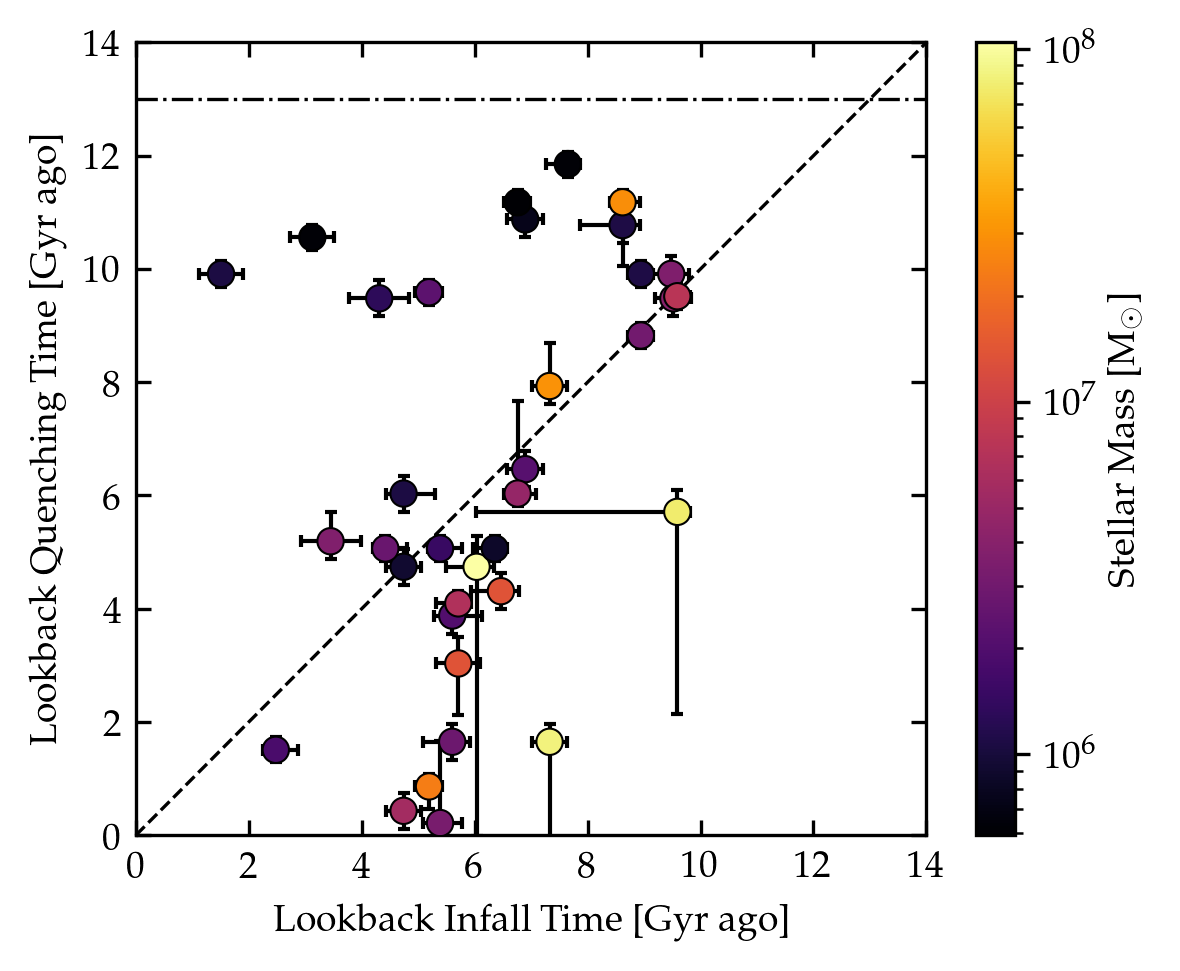

In [17]:
# initialize the figure
fig, ax = plt.subplots(1,1,figsize=(4.25,3.5),dpi=300)

data = read_timescales()
# remove the data that has tinfall=None, i.e. never infell
# remove the data for unquenched satellites
# remove the data for halos with n_star particles < 100
data = data[(~np.isnan(np.array(data.tinfall,dtype=float)))&(np.array(data.quenched,dtype=bool))&(data.n_star > 100)]

tinfall = np.array(data.tinfall, dtype=float)
tinfall_lower = np.array(data.tinfall_lower,dtype=float)
tinfall_upper = np.array(data.tinfall_upper,dtype=float)

tquench = np.array(data.tquench, dtype=float)
tquench_lower = np.array(data.tquench_lower,dtype=float)
tquench_upper = np.array(data.tquench_upper,dtype=float)

ids = np.array(data.haloid, dtype=int)
sim = np.array(data.sim, dtype=str)
mstar = np.array(data.M_star, dtype=float)

# systematic uncertainty from the time-resolution of the snapshots
h148_tq_err = 0.31722272420473 # h148 has a different set of snapshots than the other sims, so its systematic err is a bit larger
tq_err = 0.22216906137112474 # for the other sims, syst uncertainty is 0.22 Gyr

syst_err = []
for s in sim:
    if s=='h148':
        syst_err.append(h148_tq_err)
    else:
        syst_err.append(tq_err)
        
syst_err = np.array(syst_err)

# add in the systematic error to the uncertainty from the upper and lowerlimits, in quadrature
tq_upper_err = np.sqrt(np.abs(tquench-tquench_upper)**2 + syst_err**2)
tq_lower_err = np.sqrt(np.abs(tquench-tquench_lower)**2 + syst_err**2)
ti_upper_err = np.sqrt(np.abs(tinfall-tinfall_upper)**2 + syst_err**2)
ti_lower_err = np.sqrt(np.abs(tinfall-tinfall_lower)**2 + syst_err**2)

# plot the errorbars by themselves
ax.errorbar(tinfall, tquench,
             xerr = np.array([ti_upper_err, ti_lower_err]), # error is intentionally flipped
             yerr = np.array([tq_upper_err, tq_lower_err]),
             fmt = 'o',
             elinewidth=1,
             ecolor='k',
             capsize=1.5,
             capthick=1,
             mfc = 'none', # no marker color -- just errorbars
             mec = 'none',
             ms = 0,
             zorder = 10)

# now plot the points on top of the errorbars, with a colormap for the stellar mass
im = ax.scatter(tinfall, tquench,
                 c = mstar,
                 linewidths = 0.5,
                 edgecolors = 'k',
                 cmap = 'inferno', 
                 norm = mpl.colors.LogNorm(), # logarithmic normalization for the mass
                 marker = 'o',
                 s = 40,
                 zorder = 11)


# plot diagonal line to separate quenching before and after infall 
ax.plot([0,20],[0,20], '--', linewidth=0.8, color='k', zorder=0) 

# plot reionization line
reiontime = 13 # in our cosmic UV model reionization occurs at z ~ 6.7 or 13 Gyr ago
ax.plot([0,20],[reiontime,reiontime], '-.', linewidth=0.8, color='k', zorder=1)

ax.set_xlabel('Lookback Infall Time [Gyr ago]')
ax.set_ylabel('Lookback Quenching Time [Gyr ago]')
ax.set_xlim(0,14)
ax.set_ylim(0,14)
ax.set_xticks([0,2,4,6,8,10,12,14])
ax.set_yticks([0,2,4,6,8,10,12,14])

cbar = plt.colorbar(im, ax = ax) 
cbar.ax.set_ylabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')

ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

plt.savefig(r'tq_ti.png', dpi=300)

plt.show()

# Quenching Timescale vs. Stellar Mass

(Akins et al. 2020, Figure 5) Quenching timescale ($t_{\text{infall}} − t_{\text{quench}}$) vs stellar mass. For halos that are quenched at $z = 0$ (red circles), this represents the time after infall until quenching, i.e. negative values indicate quenching prior to infall. For halos that are star-forming at $z = 0$ (blue diamonds), this is the Lookback Infall Time and can be interpreted physically as a lower limit on the possible quenching timescale. As in Figure 4, error bars indicate threshold variation and systematic un- certainty (added in quadrature) and halos with less than 100 star particles are excluded. Observational estimates from Fillingham et al. (2015), Wetzel et al. (2015b), and Wheeler et al. (2014) are shown in black squares, grey squares, and orange hexagons, respectively. An estimate of the quenching timescale for the SMC/LMC system is shown in purple, using the infall time estimate from Kallivayalil et al. (2013). A clear stellar mass threshold of $\sim 10^8$ solar masses is apparent, above which our satellites are largely resistant to rapid environmental quenching.

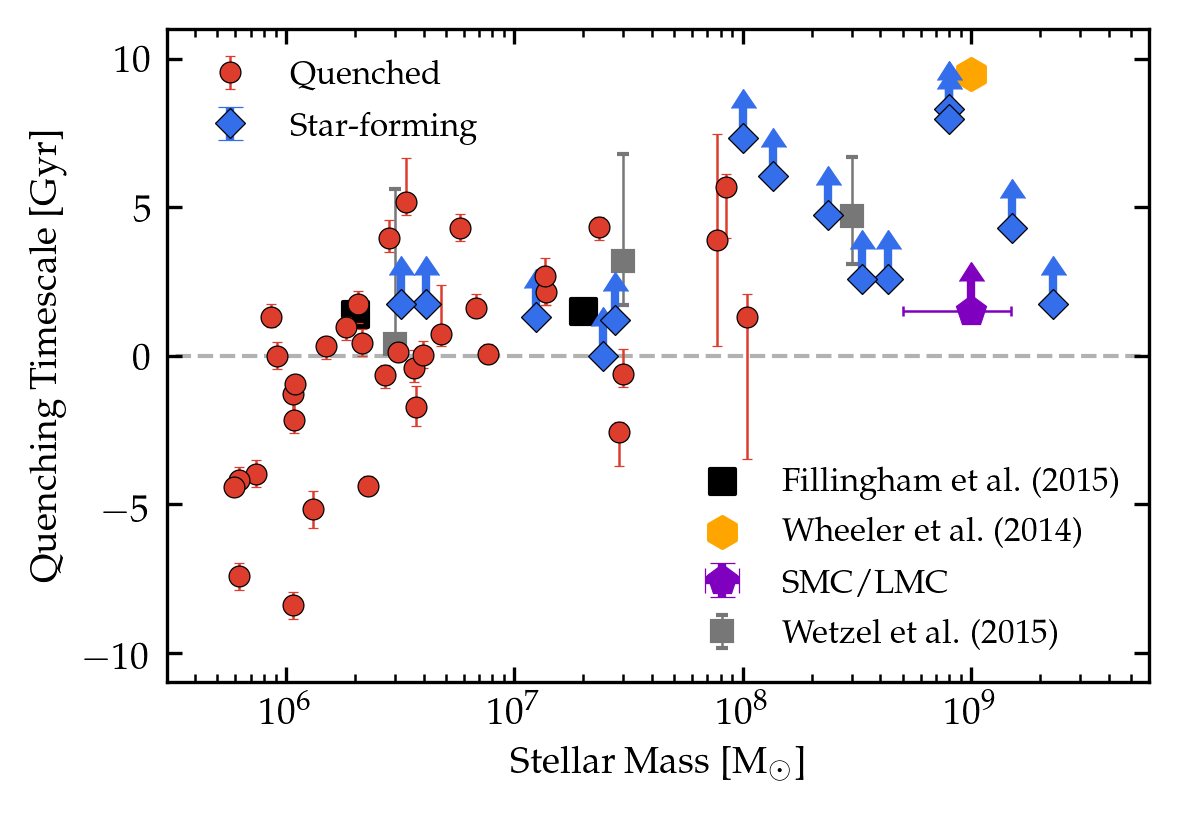

In [18]:
data = read_timescales()
# remove the halos that never infall, and those with < 100 star particles
# but keep the unquenched ones---we're interested in them now
data = data[(~np.isnan(np.array(data.tinfall,dtype=float)))&(data.n_star > 100)]

sim = np.array(data.sim,dtype=str)

h148_tq_err = 0.31722272420473
tq_err = 0.22216906137112474

syst_err = []
for s in sim:
    if s=='h148':
        syst_err.append(h148_tq_err)
    else:
        syst_err.append(tq_err)
        
syst_err = np.array(syst_err)

tinfall = np.array(data.tinfall, dtype=float)
tinfall_upper_error = np.abs(np.array(data.tinfall_upper, dtype=float) - tinfall)
tinfall_lower_error = np.abs(np.array(data.tinfall_lower, dtype=float) - tinfall)

tquench = np.array(data.tquench, dtype=float)
tquench_upper_error = np.abs(np.array(data.tquench_lower, dtype=float) - tquench) # flipped intentionally
tquench_lower_error = np.abs(np.array(data.tquench_upper, dtype=float) - tquench)

tau = tinfall - tquench # tau is the quenching timescale
tau_upper_err = np.sqrt(tquench_upper_error**2 + tinfall_upper_error**2 + 2*syst_err**2)
tau_lower_err = np.sqrt(tquench_lower_error**2 + tinfall_lower_error**2 + 2*syst_err**2)

# a simple boolean array to pick out which satellites are quenched and which aren't 
q = np.array(data.quenched,dtype=bool)


fig, ax = plt.subplots(1,1,figsize=(4,2.8),dpi=300)

# plot tau vs Mstar for *quenched satellites* as red circles, with errorbars
p1 = ax.errorbar(data.M_star[q],tau[q], # pick out only those where q is True
            yerr = np.array([tau_lower_err[q], tau_upper_err[q]]),
            elinewidth=0.6,
            mec = 'k', 
            mew = 0.3,
            ecolor='#DD3D2D',
            capsize=1.2,
            capthick=1.5,
            fmt='o', 
            color = '#DD3D2D',
            ms = 5,
            zorder=1)


# plot tau vs Mstar for *unquenched satellites* as blue diamonds, with lowerlimit arrows
p3 = ax.errorbar(data.M_star[~q], tinfall[~q],
            yerr = [1]*len(tinfall[~q]), # constant yerr means consistent arrow length
            elinewidth=2,
            mec = 'k', 
            mew = 0.3,
            ecolor='#346eeb',
            capsize=3,
            capthick=2,
            fmt='D',
            color = '#346eeb',
            ms = 5,
            lolims=True,
            zorder=1)


# zero line
ax.plot([1e2, 1e10], [0,0], 'k--', linewidth=1, alpha=0.3, zorder=0)

# add observational data from Fillingham et al (2015)
x = np.array([2e6, 2e7])
y = np.array([1.4, 1.5])
e1 = ax.scatter(x, y, marker='s', color='k')

# add observational data from Wheeler et al (2014)
x = np.array([1e9])
y = np.array([9.5])
e2 = ax.scatter(x, y, marker = 'h', color='orange', s=55)

# add SMC/LMC data from Kallivayalil
x = np.array([1e9])
y = np.array([1.5])
e3 = ax.errorbar(x, y, xerr = 0.001, yerr=1, 
            elinewidth=2,
            mec = '#8000bf', 
            mew = 0.3,
            ecolor='#8000bf',
            capsize=3,
            capthick=2,
            fmt='p',
            color = '#8000bf',
            ms = 7.5,
            lolims=True,
            zorder=1)

ax.errorbar(x, y,  xerr=5e8, marker = 'p', ms=0,
            ecolor='#8000bf',
            elinewidth=0.6,
            capsize=1.2,
            capthick=0.6,
            fmt='o')


# add observational data from Wetzel et al (2015)
x = np.array([3e4, 3e4, 3e6, 3e7, 3e8])
y = np.array([0, 1.5, 0.4, 3.2, 4.7])
y_upperlim = np.array([3, 5.95, 5.6, 6.8, 6.7])
y_lowerlim = np.array([0, 1.05, 0.4, 1.7, 3.1])
y_lower = np.abs(y-y_lowerlim)
y_upper = np.abs(y-y_upperlim)

e4 = ax.errorbar(x, y, yerr = np.array([y_lower, y_upper]), 
                elinewidth=0.6, 
                mec='#777777', 
                mew=1, 
                ecolor='#777777', 
                capsize=1.5, 
                capthick=1.5, 
                fmt='s', 
                color='#777777', 
                ms=5,
                zorder=0)


# for all the ax.errorbar commands above, we stored the output as some object (p1, e3, ...)
# now we can use those objects to manually create a legend in two parts: one for our data and one for observational data
# legend of observational data:
leg1 = ax.legend([e1,e2,e3,e4],['Fillingham et al. (2015)','Wheeler et al. (2014)','SMC/LMC', 'Wetzel et al. (2015)'], loc='lower right', frameon=False, prop={'size':8})
# legend of our data
leg2 = ax.legend([p1,p3],['Quenched', 'Star-forming'], loc='upper left', frameon=False, prop={'size':8})
ax.add_artist(leg1)

ax.set_xlim(3e5,6e9)
ax.set_ylim(-11, 11)
ax.semilogx()
ax.set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax.set_ylabel('Quenching Timescale [Gyr]')

ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

plt.tight_layout()
plt.savefig(r'tau_mass.png', dpi=300)

plt.show()